<a href="https://colab.research.google.com/github/Orange314159/DataScience/blob/main/MatthewRobsonUnit7ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q "preliz[full,notebook]"
!pip install -q bambi

In [11]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns
import bambi as bmb
import preliz as pz

# Fitting Curves: Concepts

What you'll do:

- Answer questions about what a GP is, and its relationship to GLMs and splines.
- Practice applying each of: polynomial modeling, b splines, and GPs
- You'll get a chance to read about and try to comprehend a more standard implementation of a GP.

Have fun!

**Task1**:

Why would you ever want to include a polynomial element in a model you built? What's the benefit of using polynomials to model?

So you can fit more compelx shapes of data. For example, if there is some data that increases at one point but then decreases at another, then a linear model will not work very well. By increasing to a higher polynomial we can fit this model better.

**Task2**:

Why would you ever NOT want to include a polynomial element in a model you built?

If your code is very well fit already with a lower level polynomial it would be bad to increase the degree because it will cause the model to be slower and will likely be worse than before.

**Task3**:

What's the point of using b splines?

Different sections of your data may not follow the same trends so we use b splines to differentiate different parts of data while being able to use more simple functions.

**Task4**:

Describe what a Gaussian Process is, in your own words. *Don't worry about being correct, just try to explain it to yourself*. I will not grade this question for accuracy.

I think a true Gaussian Process is the connection between all of the data points in order to perform a better approximation of the future data.

**Task5**:

Fit three models to the howell data (from Unit5ExercisesSF): polynomial, b splines, and Gaussian Process.

Plot the posterior predictive check on a scatter plot, as is standard/required.

Hint: Distributional models (variable variance) work better on the howell data.


In [2]:
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [ ]:
model_poly = bmb.Model("height ~ poly(age, degree=3)", howell, family="negativebinomial")
idata_poly = model_poly.fit()

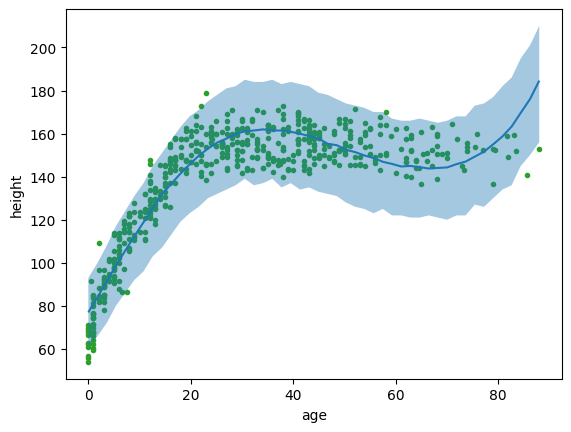

In [7]:
bmb.interpret.plot_predictions(model_poly, idata_poly, "age", pps=True)
plt.plot(howell.age, howell.height, "C2.", zorder=-3);

In [ ]:
num_knots = 5
knots = np.linspace(howell.age.min(), howell.age.max(), num_knots+2)[1:-1]
model_spline = bmb.Model("height ~ bs(age, degree=1, knots=knots)", howell, family="negativebinomial")
idata_spline = model_spline.fit(record_likelihood=True)

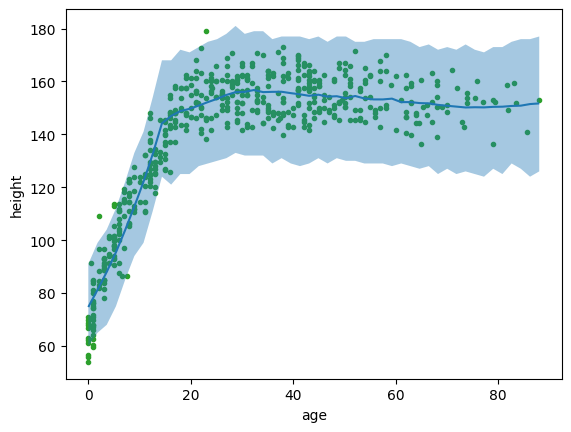

In [9]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "age", pps=True)
plt.plot(howell.age, howell.height, "C2.", zorder=-3);

In [12]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
  """Credit to  Mr. Arredondo for writing this funciton in its entirety."""
  differences = np.abs(np.subtract.outer(x_vals, x_vals))
  if l_b is None:
      l_b = np.min(differences[differences != 0]) * 2
  if u_b is None:
      u_b = np.max(differences) / 1.5

  dist = pz.InverseGamma()
  pz.maxent(dist, l_b, u_b, mass, plot=plot)

  return dict(zip(dist.param_names, dist.params))

In [13]:
height = howell["height"].values
age = howell["age"].values[:,None]

In [ ]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(age))
}

priors = {
    "hsgp(age, m=50, c=8.0)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("height ~ 0 + hsgp(age, m=50, c=8.0)", howell, family="negativebinomial", priors=priors)
idata_hsb = model_hsb.fit(record_likelihood=True)

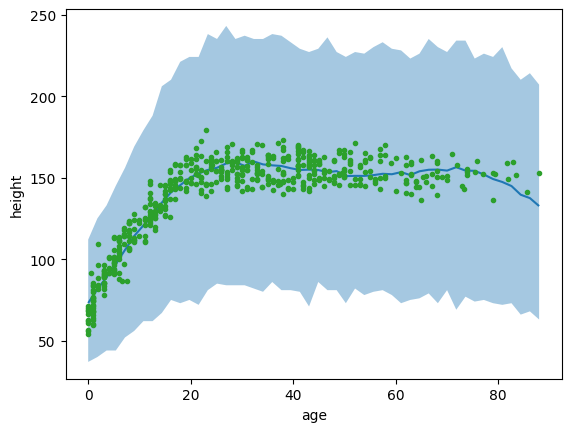

In [17]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["age"], pps = True)
ax[0].plot(howell["age"].values, howell["height"].values, "C2.");

**Task6**:

Read the article on the pymc website about GP implementation on the Mauna Loa CO$_{2}$ data combined with CO$_{2}$ ice core data from the south pole.
[Link here.](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa2.html)

Write down one thing you learned about GPs from reading the article.

Note: You probably won't understand much in this article--I had to read it about five times before I figured out what was going on. The points of this task are to: hammer home that good GP implementations are extremely technical, and increasure your exposure to the kinds of problems traditional GPs are good at solving.

One thing that I found really intresting about the GPs is that it can consider not only observation noise in the y, but also uncertainty in the input location (x). I can imagine how in future projects there could be a data set where the input location is less easy to know and how this could be a major difference over the other types of fits we use.

**Task7**:

Describe your favorite graph from the article in the previous task with as much technical detail as you can muster.

Explain why its your favorite.

![Favorite Graph](https://www.pymc.io/projects/examples/en/latest/_images/0f341c46cd1d54daa68429a992d02f5a363ba0160b8dda065995152568a20bbf.png)

This is my favorite graph mostly because of how cool it looks, but also partially because of what it represents. This graph shows how the hyperparameters are able to guessed by the hsgp. I belive that these are the posterior distributions for each of the hyperparameters. I also like the right column of graphs that can show which of the fits on the left might make less sense at particular parts relating to spikes in the graphs on the right.